## ProjF3 - Baseline Model

In [2]:
# !pip install xgboost tensorflow pandas numpy scikit-learn matplotlib statsmodels

In [1]:
#Importing all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# 1. Load and Prepare Data

In [40]:
data = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [41]:
data 

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [42]:
#Checking for duplicate rows in the dataset
print("Duplicate rows:", data.duplicated().sum())

Duplicate rows: 0


In [43]:
print(data.dtypes)

date     object
store     int64
item      int64
sales     int64
dtype: object


In [44]:
#Converting 'date' attribute to date type
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')


In [45]:
#Checking for null values in the dataset
data.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [46]:
#Correlation of each attribute with sales
corr = data.corr()
corr['sales'].sort_values(ascending=False)


sales    1.000000
date     0.195909
store   -0.008170
item    -0.055998
Name: sales, dtype: float64

####Since none of the attributes individually exhibit a strong correlation with sales, we have decided to include all attributes in the model. By considering them together, we aim to capture potential interactions and dependencies between the attributes, which can contribute to the effectiveness of the model during training.

In [47]:
'''Sorting the data according to date as it is a time-stamped dataset and it
would be convinient for traininig the models on sorted data'''

data = data.sort_values('date')

In [48]:
data.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [49]:
#Storing the rest of the data in X (train set)
X = data.copy()
X = X.reset_index(drop=True)

In [50]:
#Printing the train set
X

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-01,7,12,26
2,2013-01-01,7,46,27
3,2013-01-01,8,12,54
4,2013-01-01,9,12,35
...,...,...,...,...
912995,2017-12-31,9,34,21
912996,2017-12-31,10,34,32
912997,2017-12-31,1,35,55
912998,2017-12-31,8,33,100


In [51]:
#Printing the test set
y = test.reset_index(drop=True)
y['sales'] = np.nan 
y

,id,date,store,item,sales
0,0,2018-01-01,1,1,NaN
1,1,2018-01-02,1,1,NaN
2,2,2018-01-03,1,1,NaN
3,3,2018-01-04,1,1,NaN
4,4,2018-01-05,1,1,NaN
...,...,...,...,...,...
44995,44995,2018-03-27,10,50,NaN
44996,44996,2018-03-28,10,50,NaN
44997,44997,2018-03-29,10,50,NaN
44998,44998,2018-03-30,10,50,NaN


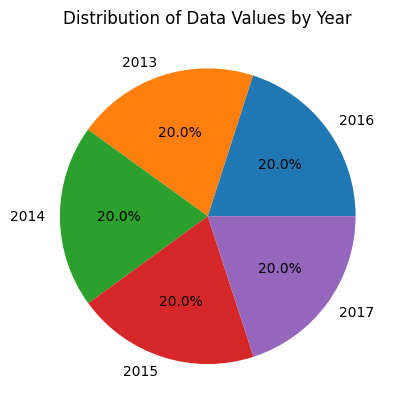

In [52]:
#Data distribution for each year in train set
X['year'] = X['date'].dt.year

year_counts = X['year'].value_counts()

plt.pie(year_counts, labels=year_counts.index, autopct='%1.1f%%')


plt.title('Distribution of Data Values by Year')


plt.show()


#### As we can see, we do not have any data imbalance in the train set. The data is distributed uniformly for each year.

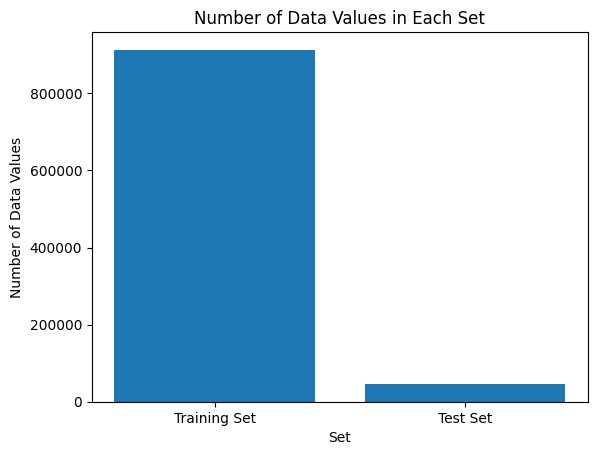

In [53]:
#Bar plot for showing the data distribution in train and test split

num_train = X.shape[0]
num_test = y.shape[0]

plt.bar(['Training Set', 'Test Set'], [num_train, num_test])

plt.title('Number of Data Values in Each Set')
plt.xlabel('Set')
plt.ylabel('Number of Data Values')

plt.show()


# 2. Preparing Baseline Models

## LSTM

In [54]:
X_lstm = X.copy()

In [55]:
X_lstm

,date,store,item,sales,year
0,2013-01-01,1,1,13,2013
1,2013-01-01,7,12,26,2013
2,2013-01-01,7,46,27,2013
3,2013-01-01,8,12,54,2013
4,2013-01-01,9,12,35,2013
...,...,...,...,...,...
912995,2017-12-31,9,34,21,2017
912996,2017-12-31,10,34,32,2017
912997,2017-12-31,1,35,55,2017
912998,2017-12-31,8,33,100,2017


In [26]:
# Converting 'date' column to ordinal to use it as a feature
X_lstm['date'] = X_lstm['date'].apply(lambda x: x.toordinal())

In [27]:
X_lstm

,date,store,item,sales,year
0,734869,1,1,13,2013
1,734869,7,12,26,2013
2,734869,7,46,27,2013
3,734869,8,12,54,2013
4,734869,9,12,35,2013
...,...,...,...,...,...
912995,736694,9,34,21,2017
912996,736694,10,34,32,2017
912997,736694,1,35,55,2017
912998,736694,8,33,100,2017


In [28]:
# Dropping 'year' column as it is redundant
X_lstm.drop(columns=['year'], inplace=True)

In [29]:
# Feature scaling
scaler = MinMaxScaler()
X_lstm[['date', 'store', 'item']] = scaler.fit_transform(X_lstm[['date', 'store', 'item']])
y = scaler.fit_transform(X_lstm[['sales']])

In [30]:
#X_lstm['date'].unique()

In [31]:
# Defining function to create sequences
def create_sequences(X, y, time_steps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [32]:
# Creating sequences for LSTM model
X_seq, y_seq = create_sequences(X_lstm[['date', 'store', 'item']].values, y)

# Splitting the dataset into train and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [33]:
# Define and compile the LSTM model
lstm_model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mse')

In [34]:
# Train the model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25
20543/20543 [==============================] - 21s 1ms/step - loss: 0.0149 - val_loss: 0.0146
Epoch 2/25
20543/20543 [==============================] - 21s 1ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 3/25
20543/20543 [==============================] - 21s 1ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 4/25
20543/20543 [==============================] - 21s 1ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 5/25
20543/20543 [==============================] - 21s 1ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 6/25
20543/20543 [==============================] - 21s 1ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 7/25
20543/20543 [==============================] - 21s 1ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 8/25
20543/20543 [==============================] - 21s 1ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 9/25
20543/20543 [==============================] - 21s 1ms/step - loss: 0.0136 - val_loss: 0.0135
Epoch 10/25
20543/20543 [==============================

In [35]:
# Evaluating the model
test_loss_lstm = lstm_model.evaluate(X_test_lstm, y_test_lstm)
print("Test Loss:", test_loss_lstm)

5707/5707 [==============================] - 2s 406us/step - loss: 0.0135
Test Loss: 0.013451041653752327


## Linear Regression

In [66]:
X_xg = X.copy()

In [67]:
X_xg

,date,store,item,sales,year
0,2013-01-01,1,1,13,2013
1,2013-01-01,7,12,26,2013
2,2013-01-01,7,46,27,2013
3,2013-01-01,8,12,54,2013
4,2013-01-01,9,12,35,2013
...,...,...,...,...,...
912995,2017-12-31,9,34,21,2017
912996,2017-12-31,10,34,32,2017
912997,2017-12-31,1,35,55,2017
912998,2017-12-31,8,33,100,2017


In [68]:
X_xg['day'] = X_xg['date'].dt.day
X_xg['month'] = X_xg['date'].dt.month
X_xg['year'] = X_xg['date'].dt.year


X_xg.drop(columns=['date'], inplace=True)

scaler = MinMaxScaler()
X_xg = scaler.fit_transform(X_xg)


y_xg = X_xg[:, -1]


X_xg = X_xg[:, :-1]


In [69]:
y_xg

array([0., 0., 0., ..., 1., 1., 1.])

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_xg, y_xg, test_size=0.2, shuffle=False, random_state = 42)

In [75]:
# Initialize and train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)

y_pred_xg = linear_model.predict(X_test)
y_train_pred = linear_model.predict(X_train)
mse_xg_train = mean_squared_error(y_train, y_train_pred)
mse_xg = mean_squared_error(y_test, y_pred_xg)
print("Mean Squared Error Train:", mse_xg_train)
print("Mean Squared Error Test:", mse_xg)


Mean Squared Error Train: 0.09749153679774702
Mean Squared Error Test: 0.09750570285687096


## MLPRegressor


In [76]:
r_x = X.copy()

In [77]:
r_x

,date,store,item,sales,year
0,2013-01-01,1,1,13,2013
1,2013-01-01,7,12,26,2013
2,2013-01-01,7,46,27,2013
3,2013-01-01,8,12,54,2013
4,2013-01-01,9,12,35,2013
...,...,...,...,...,...
912995,2017-12-31,9,34,21,2017
912996,2017-12-31,10,34,32,2017
912997,2017-12-31,1,35,55,2017
912998,2017-12-31,8,33,100,2017


In [78]:
# Converting 'date' column to ordinal to use it as a feature
r_x['date'] = r_x['date'].apply(lambda x: x.toordinal())

In [79]:
# Dropping the 'sales' column from features
R_X = r_x.drop(columns=['sales'])

# Target variable for training set
y_train = r_x['sales'].values.reshape(-1, 1)  # Reshape y_train into a 2D array

# Features for training set (dropping 'date' and 'sales' columns)
# X_train = r_x.drop(columns=['date', 'sales'])
X_train = R_X

# Preprocessing: Scale the features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)

In [80]:
# Splitting the data into training and testing sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

In [83]:
# Initialize and train MLP Regressor
mlp_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=50, random_state=42)
mlp_model.fit(X_train_split, y_train_split)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=50, random_state=42)

In [84]:
# Predicting on the training set
y_train_pred = mlp_model.predict(X_train_split)

# Calculating Mean Squared Error on training set
mse_rf_train = mean_squared_error(y_train_split, y_train_pred)
print("Mean Squared Error on Training Set:", mse_rf_train)

Mean Squared Error on Training Set: 485.6661055876162


In [85]:
# Predicting on the testing set
y_pred = mlp_model.predict(X_test_split)

# Evaluating the model
mse_rf_test = mean_squared_error(y_test_split, y_pred)
print("Mean Squared Error:", mse_rf_test)

Mean Squared Error: 485.5046464459794


## MLP

In [86]:
r_x = X.copy()

In [87]:
# Converting 'date' column to ordinal to use it as a feature
r_x['date'] = r_x['date'].apply(lambda x: x.toordinal())

In [88]:
R_X = r_x.drop(columns=['sales'])  # Dropping the 'sales' column from features
y_train = r_x['sales']  # Target variable for training set
#X_train = r_x.drop(columns=['date', 'sales'])  # Features for training set (dropping 'date' and 'sales' columns)
X_train = R_X
# Preprocessing: Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
y = scaler.fit_transform(r_x[['sales']])

# Splitting the data into training and testing sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_scaled, y, test_size=0.2, random_state=42)

In [92]:
# Define the model architecture
mlp_model = Sequential()
mlp_model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))
mlp_model.add(Dense(1, activation='linear'))  # Output layer

# Compile the model
mlp_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
mlp_model.fit(X_train_split, y_train_split, epochs=20, batch_size=32, validation_split=0.1)

# Predicting on the testing set
y_pred_mlp = mlp_model.predict(X_test_split)

# Evaluating the model
mse_mlp = mean_squared_error(y_test_split, y_pred_mlp)
print("Mean Squared Error (MLP):", mse_mlp)

Epoch 1/20
20543/20543 [==============================] - 6s 272us/step - loss: 0.0127 - val_loss: 0.0123
Epoch 2/20
20543/20543 [==============================] - 6s 276us/step - loss: 0.0112 - val_loss: 0.0107
Epoch 3/20
20543/20543 [==============================] - 6s 277us/step - loss: 0.0108 - val_loss: 0.0106
Epoch 4/20
20543/20543 [==============================] - 6s 278us/step - loss: 0.0105 - val_loss: 0.0106
Epoch 5/20
20543/20543 [==============================] - 6s 293us/step - loss: 0.0103 - val_loss: 0.0102
Epoch 6/20
20543/20543 [==============================] - 6s 292us/step - loss: 0.0103 - val_loss: 0.0101
Epoch 7/20
20543/20543 [==============================] - 6s 276us/step - loss: 0.0102 - val_loss: 0.0100
Epoch 8/20
20543/20543 [==============================] - 6s 276us/step - loss: 0.0102 - val_loss: 0.0101
Epoch 9/20
20543/20543 [==============================] - 6s 291us/step - loss: 0.0101 - val_loss: 0.0099
Epoch 10/20
20543/20543 [=====================

# 3. Baseline Performance


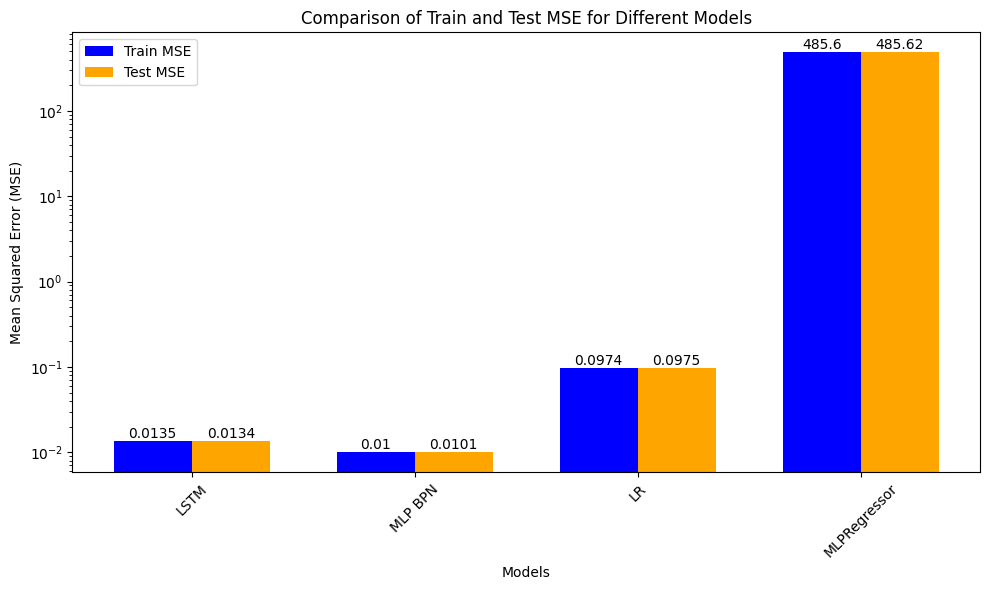

In [93]:
import matplotlib.pyplot as plt
import numpy as np

models = ['LSTM', 'MLP BPN','LR', 'MLPRegressor']

# Train MSE values
train_mse = [0.0135, 0.01, 0.0974, 485.60]

# Test MSE values
test_mse = [0.0134, 0.0101, 0.0975, 485.62]

# Plotting
plt.figure(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(models))

bars1 = plt.bar(index, train_mse, bar_width, color='blue', label='Train MSE')
bars2 = plt.bar(index + bar_width, test_mse, bar_width, color='orange', label='Test MSE')

plt.yscale('log')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Train and Test MSE for Different Models')
plt.legend()
plt.xticks(index + bar_width / 2, models, rotation=45)

for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), va='bottom', ha='center')

plt.tight_layout()
plt.show()
